# **VIOLENCE DETECTION V1.0**

----------------------------------------------------------------
# **CONNECTION** (google drive)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive
!ls

Mounted at /gdrive
/gdrive/My Drive
 Cartoni	    data   images	   results	 results_datasets.csv
'Colab Notebooks'   Film   registrazioni   results.csv	'Serie TV'


# **DATA PREPROCESSING**
As a **preparation** for the **graph input** few steps were taken in the dataset preparation
- initially the **videos** were **sampled** to a frame by **frame sequence** as we were limited with computational power. 
- The videos were sampled into a **fix number** of **frames** before given as an input to the model. 

- For all dataset combination of **augmentation methods** were used and for some of the datasets, **dark edges** were **removed** from the frame as we present in Figure 3.
- As the original article stated, the **input** to the model is a **subtraction** of **adjacent frames**, this was done in order to include a **spatial movements** in the input videos instead of the raw pixels from each frame. 
- In Figure 2 we present and example of difference computation of adjacent frames where an hockey player pushes another player.

-To enrich and **enlarge** the **dataset** we apply **data augmentation** with the following
**transformations** on the frames:
  - **Image cropping**: a **slicing** of the **image**, done each time with a **different** anchor **corner** was chosen (Figure 4) .
  - **Image transpose**: as a complement steps to the cropping process, a transpose was done, this **step** was done during the **fit generator process** (Figure 5)

**SAVE_FIGURES_FROM_VIDEO** (required for CREATE DATASET)

In [ ]:
import os
import cv2

def save_figures_from_video(dataset_video_path, video_filename, suffix,figures_path,skip_frames = 25,apply_norm = True, apply_diff = True,fix_len = None):
    seq_len = 0

    video_figures_path = os.path.join(figures_path ,video_filename)
    if not os.path.exists(video_figures_path):
        os.makedirs(video_figures_path)

    video_file = os.path.join(dataset_video_path, video_filename + suffix)
    label = 0
    #print('Extracting frames from video: ', video_file)
    print('.', end='')

    videoCapture = cv2.VideoCapture(video_file)
    if fix_len is not None:
        vid_len = int(videoCapture.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames = int(float(vid_len)/float(fix_len))
    videoCapture.set(cv2.CAP_PROP_POS_MSEC, (seq_len * skip_frames))
    success, figure_ = videoCapture.read()
    success = True
    files = []
    while success:
        success, figure = videoCapture.read()

        if seq_len % skip_frames == 0:
            if success:
                figure_curr = figure
                image_file = os.path.join(video_figures_path , "frame_%d.jpg" % seq_len)
                files.append(image_file)
                cv2.imwrite(image_file, figure_curr)
        seq_len += 1
    video_images = dict(images_path = video_figures_path, name = video_filename,
                        images_files = files, sequence_length = seq_len, label = label)

    return video_images


In [ ]:
import pickle

datasets_videos = dict(
    hocky = dict(hocky="data/raw_videos/HockeyFights"),
    violentflow = dict(violentflow="data/raw_videos/violentflow"),
    movies = dict(movies="data/raw_videos/movies")
)

#for dataset_name, dataset_videos in datasets_videos.items():
dataset_name = "violentflow"                          #         "movies"  "violentflow"   "hocky"
dataset_videos = datasets_videos.get("violentflow")   #         "movies"  "violentflow"   "hocky"
print(dataset_name, dataset_videos)

force=False           #True to force rebuilding dataset
videos_seq_length = []
datasets_images = {}
videos_frames_paths = []
videos_labels = []
datasets_video_path = dataset_videos
figure_output_path = "data/raw_frames"

#Extract images for each video for the dataset
for dataset_name, dataset_video_path in datasets_video_path.items():
    dataset_figures_path = os.path.join(figure_output_path,dataset_name)
    if not os.path.exists(dataset_figures_path):
        os.makedirs(dataset_figures_path)
    dataset_images = []
    
    for filename in os.listdir(dataset_video_path):
        if filename.endswith(".avi") or filename.endswith(".mpg"):
            video_images_file = os.path.join(dataset_figures_path,filename[:-4], 'video_summary.pkl')
            if os.path.isfile(video_images_file) and not force:
                with open(video_images_file, 'rb') as f:
                    video_images = pickle.load(f)               #load dump of frames already decomposed
            else:
                video_images = save_figures_from_video(dataset_video_path, filename[:-4],filename[-4:], dataset_figures_path, fix_len = 20)
                if dataset_name == "hocky":
                    if filename.startswith("fi"):
                        video_images['label'] = 1
                elif dataset_name == "violentflow":
                    if "violence" in filename:
                        video_images['label'] = 1
                elif dataset_name == "movies":
                    if "fi" in filename:
                        video_images['label'] = 1
                with open(video_images_file, 'wb') as f:
                    pickle.dump(video_images, f, pickle.HIGHEST_PROTOCOL)
            dataset_images.append(video_images)
            videos_seq_length.append(video_images['sequence_length'])
            videos_frames_paths.append(video_images['images_path'])
            videos_labels.append(video_images['label'])
    datasets_images[dataset_name] = dataset_images
avg_length = int(float(sum(videos_seq_length)) / max(len(videos_seq_length), 1))

#print(videos_seq_length)
print(videos_frames_paths)
print(videos_labels)

violentflow {'violentflow': 'data/raw_videos/violentflow'}
['data/raw_frames/violentflow/balcony_football_violence__Brannik_Football_Violence__Nattevandring__ysW-tGv-YjI', 'data/raw_frames/violentflow/balcony_football_violence__British_Football_Hooligans_Mix_3__MorningGlory1997__kW23lUV6oFk', 'data/raw_frames/violentflow/crowd_violence__Man_Utd_vs_Roma_Crowd_Trouble__uncychris__ZGI5vlDMpJA', 'data/raw_frames/violentflow/crowd_violence__Roma_V_Man_Utd_Police_beating_crowd__Beck84Utd__jwtg8AkcAfc', 'data/raw_frames/violentflow/fans_violence__BRANNIK_Football_Violence_CSKA__Arpecua__gew9Ks_9VRU', 'data/raw_frames/violentflow/fans_violence__Fans_Fighting_Roma_vs_Man_Utd__teafor22__oYikreK6ng4', 'data/raw_frames/violentflow/fans_violence__Roma_vs_Man_United_Police_violence_DANISH_TV__7Anotnac7__gIfgEwL', 'data/raw_frames/violentflow/fans_violence__Slovak_chauvinism_nationalism_extremism_intolerance_and_all_form', 'data/raw_frames/violentflow/fans_violence__THE_BEST_HOOLIGANS_Los_hinchas_ult

# **Train / Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
#split up our data into a  training and test set
train_path, test_path, train_y, test_y =  train_test_split(videos_frames_paths,videos_labels, test_size=0.20, random_state=42)

# if apply_aug:
#     aug_paths = []
#     aug_y = []
#     for train_path_, train_y_ in zip(train_path,train_y):
#
#         aug_path = generate_augmentations(train_path_,force = False)
#         aug_paths.append(aug_path)
#         aug_y.append(train_y_)
#
#     train_path = train_path + aug_paths
#     train_y = train_y + aug_y

train_path, valid_path, train_y, valid_y = train_test_split(train_path, train_y, test_size=0.20, random_state=42)
print("Dataset splitted")

Dataset splitted


----------------------------------------------------------------------------
# **GET SEQUENCES:** 
it makes sequence of adjacent images

Requires:
- FRAME_LOADER
- CROP_IMG_REMOVE_DARK: removes black border background from image
- CROP_IMG: cuts the image to a random side (Center, left up, left down, right up, right down)


In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
import random
corner_keys = ["Center","Left_up","Left_down","Right_up","Right_down"]

def frame_loader(frames,figure_shape,to_norm = True):
    output_frames = []
    for frame in frames:
        image = load_img(frame, target_size=(figure_shape, figure_shape),interpolation='bilinear')
        img_arr = img_to_array(image)
        # Scale
        figure = (img_arr / 255.).astype(np.float32)
        # Normalize
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        figure = (figure - mean) / std
        output_frames.append(figure)
    return output_frames


def crop_img__remove_Dark(img, x_crop,y_crop, x,y, figure_size):
    x_start = x_crop
    x_end = x-x_crop
    y_start = y_crop
    y_end = y-y_crop
    return cv2.resize(img[y_start:y_end,x_start:x_end,:],(figure_size,figure_size))


def crop_img(img, figure_shape, percentage=0.8, corner="Left_up"):
    if (corner == None):
        corner = random.choice(corner_keys)
    if corner not in corner_keys:
        raise ValueError('Invalid corner method {} specified. Supported corners are {}'.format(corner, ", ".join(corner_keys)))

    resize = int(figure_shape*percentage)

    if (corner =="Left_up"):
        x_start = 0
        x_end = resize
        y_start = 0
        y_end = resize
    if (corner == "Right_down"):
        x_start = figure_shape-resize
        x_end = figure_shape
        y_start = figure_shape-resize
        y_end = figure_shape
    if (corner =="Right_up"):
        x_start = 0
        x_end = resize
        y_start = figure_shape-resize
        y_end = figure_shape
    if (corner == "Left_down"):
        x_start = figure_shape-resize
        x_end = figure_shape
        y_start = 0
        y_end = resize
    if (corner == "Center"):
        half = int(figure_shape*(1-percentage))
        x_start = half
        x_end = figure_shape-half
        y_start = half
        y_end = figure_shape-half

    img = cv2.resize(img[y_start:y_end,x_start:x_end, :], (figure_shape, figure_shape)).astype(np.float32)
    return img


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import scipy
import glob
Debug_Print_AUG=True     # True to save augmented images

def get_sequences(data_paths, labels, figure_shape, seq_length, classes=1, use_augmentation = False, use_crop=True, crop_x_y=None):
    X, y = [], []
    seq_len = 0
    for data_path, label in zip(data_paths,labels):
        frames = sorted(glob.glob(os.path.join(data_path, '*jpg')))
        x = frame_loader(frames, figure_shape)

        if (crop_x_y):                                                            #remove dark from background
            x = [crop_img__remove_Dark(x_,crop_x_y[0],crop_x_y[1],x_.shape[0],x_.shape[1],figure_shape) for x_ in x]
        
        if use_augmentation:                                                      #data augmentation
            rand = scipy.random.random()
            corner=""
            if rand > 0.5:
                if (use_crop):
                    corner= random.choice(corner_keys)
                    x = [crop_img(x_,figure_shape, 0.7, corner) for x_ in x]        #crop random corner of an image
                x = [frame.transpose(1, 0, 2) for frame in x]                     #transpose 

                if (Debug_Print_AUG):                                             #to save augm. image on disk
                    to_write = [list(a) for a in zip(frames, x)]
                    [cv2.imwrite(x_[0] + "_" + corner, x_[1] * 255) for x_ in to_write]

        x = [x[i] - x[i+1] for i in range(len(x)-1)]                              #subtraction of adjacent frames
        X.append(x)
        y.append(label)
    X = pad_sequences(X, maxlen=seq_length, padding='pre', truncating='pre')
    
    if classes > 1:                        #only for categorical crossentropy
        x_ = to_categorical(x_,classes)
    return np.array(X), np.array(y)


# **DATA GENERATOR** 
- requires GET SEQUENCES

Data generators allow to feed the model with large data, with the yield that returns part of the data gradually.

In [ ]:
from numpy.random import shuffle
def data_generator(data_paths, labels, batch_size, figure_shape, seq_length, use_aug, use_crop, crop_x_y, classes = 1):
    while True:
        indexes = np.arange(len(data_paths))
        np.random.shuffle(indexes)
        select_indexes = indexes[:batch_size]
        data_paths_batch = [data_paths[i] for i in select_indexes]
        labels_batch = [labels[i] for i in select_indexes]

        X, y = get_sequences(data_paths_batch, labels_batch, figure_shape, seq_length, classes, use_augmentation = use_aug, use_crop=use_crop, crop_x_y=crop_x_y)

        yield X, y

In [ ]:
crop_dark = dict(
    hocky = (11, 38),
    violentflow = None,
    movies = None
)

crop_x_y = None
if (crop_dark):   #None
    crop_x_y = crop_dark[dataset_name]

batch_size = 2                  #16
len_train, len_valid = len(train_path), len(valid_path)       #fig size #fix len    #False
print(len_train, len_valid, len(test_path))

train_gen =    data_generator(train_path, train_y, batch_size, 244, 20, use_aug=True,  use_crop=True,  crop_x_y=crop_x_y, classes=1)
validate_gen = data_generator(valid_path, valid_y, batch_size, 244, 20, use_aug=False, use_crop=False, crop_x_y=crop_x_y, classes=1)

test_x, test_y = get_sequences(test_path, test_y, 244, 20, crop_x_y=crop_x_y, classes=1)


156 40 50


# **ARCHITECTURE**
We describe the **architecture** build upon four type of layers, 
- The **first** is the **input layer** that receive a sequence of 10 frames that are a computed difference of two adjacent frames from the original video.

- The **second** type of **layers** belongs to a **Resnet50 CNN network** that aim to classify images, the initial weights of the layers are taken form a pre-trained model on **image-net**, the CNN process each frame separately and during training the weights of the network are shared. 

- The **third layer** is the **Convolution LSTM (ConvLSTM)** where each frame from the CNN enters into a **ConvLSTM** cell with an hidden state of **256 convolution filters** of **size 3**. 

- The **forth** type of **layers** process the ConvLSTM and **output** the **binary prediction**, a **Max pooling layer** of **size 2** reduces the data and chooses the most informational pixels, then the data is **batch normalized** and connected to a series of **fully connected layer** of sizes **1000, 256, 10** and finally a **binary output perception** with a **sigmoid activation function**. 
- **Between** each of the **fully connected layers** we use** RELU activation**.

- We use **binary cross entropy** as our **loss function** and **RMSprop** as an **optimizer**, **20%** of the data is select for **validation** and rest **80%** is selected to **train**. 

- The **learning rate** of the network **starts** with value of **0.0001** and is **reduced** by **half** **after 5 epochs** of **no improvement** in the **validation loss**. 

- We train the model with **50 epochs** but also use **early stopping** in case where the **network validation loss haven't improve for 15 epochs.**

model fit: # the network is trained on data generatores and apply the callacks when the validation loss is not improving:
- 1) early stop to training after n iteration
- 2) reducing the learning rate after k iteration where k< n

In [ ]:
import tensorflow
from numpy.random import seed
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten, Dropout, ConvLSTM2D, BatchNormalization, Activation, Reshape
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (MaxPooling2D)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K    #added
K.clear_session()                 #added

tensorflow.random.set_seed(2)
seed(1)

initial_weights = 'glorot_uniform'       #'Xavier'

input_layer = Input(shape=(20, 244, 244, 3))
cnn = ResNet50(weights= 'imagenet' , include_top=False, input_shape =(244, 244, 3))                   #VGG19 (without input shape)
for layer in cnn.layers:      #retrain
    layer.trainable = True                  #False if static

dropout = 0.0           #0.5
cnn = TimeDistributed(cnn)(input_layer)

# cnn = Reshape((20,4, 4, 128), input_shape=(20,1, 1, 2048))(cnn)                               #the resnet output shape is 1,1,20148 and need to be reshape for the ConvLSTM filters
lstm = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding='same', return_sequences=False)(cnn)     #long short time memory 2 dimension
lstm = MaxPooling2D(pool_size=(2, 2))(lstm)
flat = Flatten()(lstm)

flat = BatchNormalization()(flat)
#flat = Dropout(dropout)(flat)      #don't use dropout
linear = Dense(1000)(flat)

relu = Activation('relu')(linear)
linear = Dense(256)(relu)
#linear = Dropout(dropout)(linear)
relu = Activation('relu')(linear)
linear = Dense(10)(relu)
#linear = Dropout(dropout)(linear)
relu = Activation('relu')(linear)
predictions = Dense(1 , activation='sigmoid')(relu)     # classes = 1           #'softmax' if classes > 1

model = Model(inputs=input_layer, outputs=predictions)

model.compile(optimizer= RMSprop(learning_rate = 0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])       #Adam, 1e-4, 1e-3     #'categorical_crossentropy' if classes >1
model.summary()

batch_epoch_ratio = 0.5         #1

hist = model.fit(train_gen, validation_data = validate_gen,
    steps_per_epoch= int(float(len_train) / float(batch_size * batch_epoch_ratio)),
    epochs = 50,                   
    validation_steps = int(float(len_valid) / float(batch_size)),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, ),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5 , min_lr=1e-8, verbose=1)]
                #TestCallback((test_x, test_y))
)

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 244, 244, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 8, 8, 2048)    23587712  
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 8, 8, 256)         21234688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
______________________________________________________________

# **EVALUATION**
- The hyper-tunning process as mentioned in section 4.3 allows us to find the best performing parameters of the network based on the "Hockey" dataset. 
the chosen architecture is already presented in the section 4.1. 
- In Figure 6 we present the hyper-tunning test accuracy for each of the hyper-parameters values.
- The best performing **CNN** is the **Resnet50** with **90% accuracy**, the InceptionV3 CNN was not far from the Resnet50 with 89% accuracy but the VGG19 CNN had poor results of only 79% accuracy.
- The **starting learning rate** value had a critical effect on the network results where the 0.001 learning rate resolved with only 46% accuracy which is lower then the random classiffcation. 
as already mentioned by the original paper, the **learning rate** of **0.0001** had far better results in all experiments.
- The **augmentation** increases the accuracy by** 4.5%** and smaller length size of the **sequence** improve the accuracy by **2%.** 
the dropout of 50% did no improve the model performance and results with only 86% accuracy. 
- As expected the static CNN configuration where the CNN weights are not retrained had very poor results of 59% accuracy.


25/25 [==============================] - 9s 283ms/step - loss: 1.2104 - accuracy: 0.7600
[<tensorflow.python.keras.metrics.Mean object at 0x7f1e480f2250>, <tensorflow.python.keras.metrics.MeanMetricWrapper object at 0x7f1e176346d0>]
Loss: 1.2103592157363892
Test accuracy: 0.7599999904632568


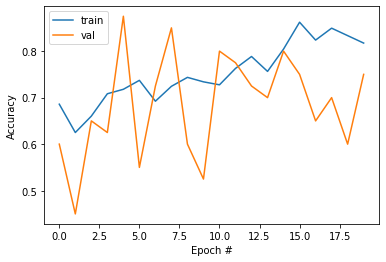

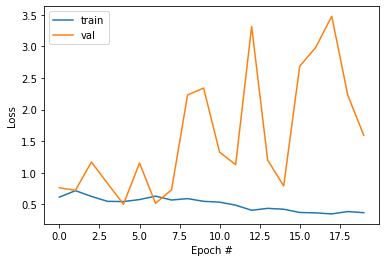

In [ ]:
import matplotlib.pyplot as plt

score = model.evaluate(test_x, test_y, batch_size=2)
print(model.metrics)
print('Loss:', score[0])
print('Test accuracy:', score[1])

########################### ACCURACY ###################################################
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##################### LOSS ###############################
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
#plt.title('model loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true, y_pred)
  plt.imshow(conf_matrix)
  plt.xticks([0, 1], ['NonViolence', 'Violence'], fontsize=16)
  plt.yticks([0, 1], ['NonViolence', 'Violence'], fontsize=16)
  plt.ylabel('Truth', fontsize=20)
  plt.xlabel('Prediction', fontsize=20)
  plt.colorbar()

  plt.grid(False)
  plt.show()

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0
 1 0 1 1 0 0 1 0 1 0 0 1 0]
[1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 1 0 0 1 0 0 1 1 0 0 1 1 1]


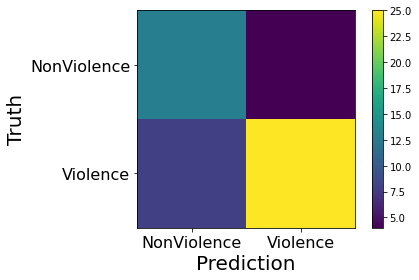

In [ ]:
prediction_probabilities = (model.predict(test_x, batch_size=2).ravel()>0.5)+0
print(prediction_probabilities)
print(test_y)
plot_confusion(test_y, prediction_probabilities)